In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D  # これが必要
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# Code for Fig 4.
- graph_norm.csv and gea.csv are from [preprocess_fig4.ipynb](https://github.com/inoue0426/drGAT/blob/main/Figs/preprocess_fig4.ipynb)
- pubchem.csv is from [Fig2.ipynb](https://github.com/inoue0426/drGAT/blob/main/Figs/Fig2.ipynb)
- pubchem.csv is from [Fig2.ipynb](https://github.com/inoue0426/drGAT/blob/main/Figs/Fig2.ipynb)

In [2]:
tmp = pd.read_csv("nsc_cid_smiles_class_name.csv", usecols=["NAME", "MECHANISM", "NSC"])
tmp.columns = ["nsc", "moa", "drug"]

In [3]:
gea = pd.read_csv("gsea_results.csv", index_col=0).merge(tmp, how="left")

In [4]:
gea["moa"] = gea["moa"].apply(lambda x: "Other" if x == "Acetalax" else x)
gea["moa"] = gea["moa"].fillna("Other")
gea = gea[gea["moa"] != "Other"]

In [5]:
gea["moa"].value_counts()
gea.Term = gea.Term.replace("Pperoxisome", "Peroxisome")

In [6]:
df = pd.read_csv(
    "moa_with_top5.csv",
    # usecols=['NSC', 'drug', 'gene', 'num', 'dti_existed']
)
atten = pd.read_csv("attention_.csv.gz", index_col=0)
atten.index = atten.index.astype(str)
df["atten_score"] = [atten.loc[str(i), j] for i, j in zip(df["NSC"], df["gene"])]
df.head()

/tmp/ipykernel_480386/708773322.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  atten = pd.read_csv('attention_.csv.gz', index_col=0)


,Unnamed: 0,NSC,drug,gene,num,rank,dti_existed,predicted_positive,drug_gene,pubmed_hit,top5,key,MECHANISM,atten_score
0,0,740,Methotrexate,TYMS,67,3,1,1,740_TYMS,True,True,740_TYMS,DNA,0.003082
1,1,740,Methotrexate,ATIC,67,1,1,1,740_ATIC,True,True,740_ATIC,DNA,0.003178
2,2,752,Thioguanine,BST2,0,5,0,0,752_BST2,False,True,752_BST2,DNA,0.003526
3,3,752,Thioguanine,APBB1IP,0,1,0,0,752_APBB1IP,False,True,752_APBB1IP,DNA,0.003644
4,4,752,Thioguanine,SLC43A3,2,3,0,1,752_SLC43A3,True,True,752_SLC43A3,DNA,0.003538


In [7]:
drugs = df[
    df.drug.isin(
        [
            "Gefitinib",
            "Vemurafenib",
            "Nilotinib",
            "Dovitinib",
            "Erlotinib hydrochloride",
        ]
    )
]

drugs = drugs[drugs["NSC"] != 715055]
G = nx.from_pandas_edgelist(drugs, source="drug", target="gene")
nx.is_connected(G)
drugs["drug"] = drugs["drug"].replace("Erlotinib hydrochloride", "Erlotinib")

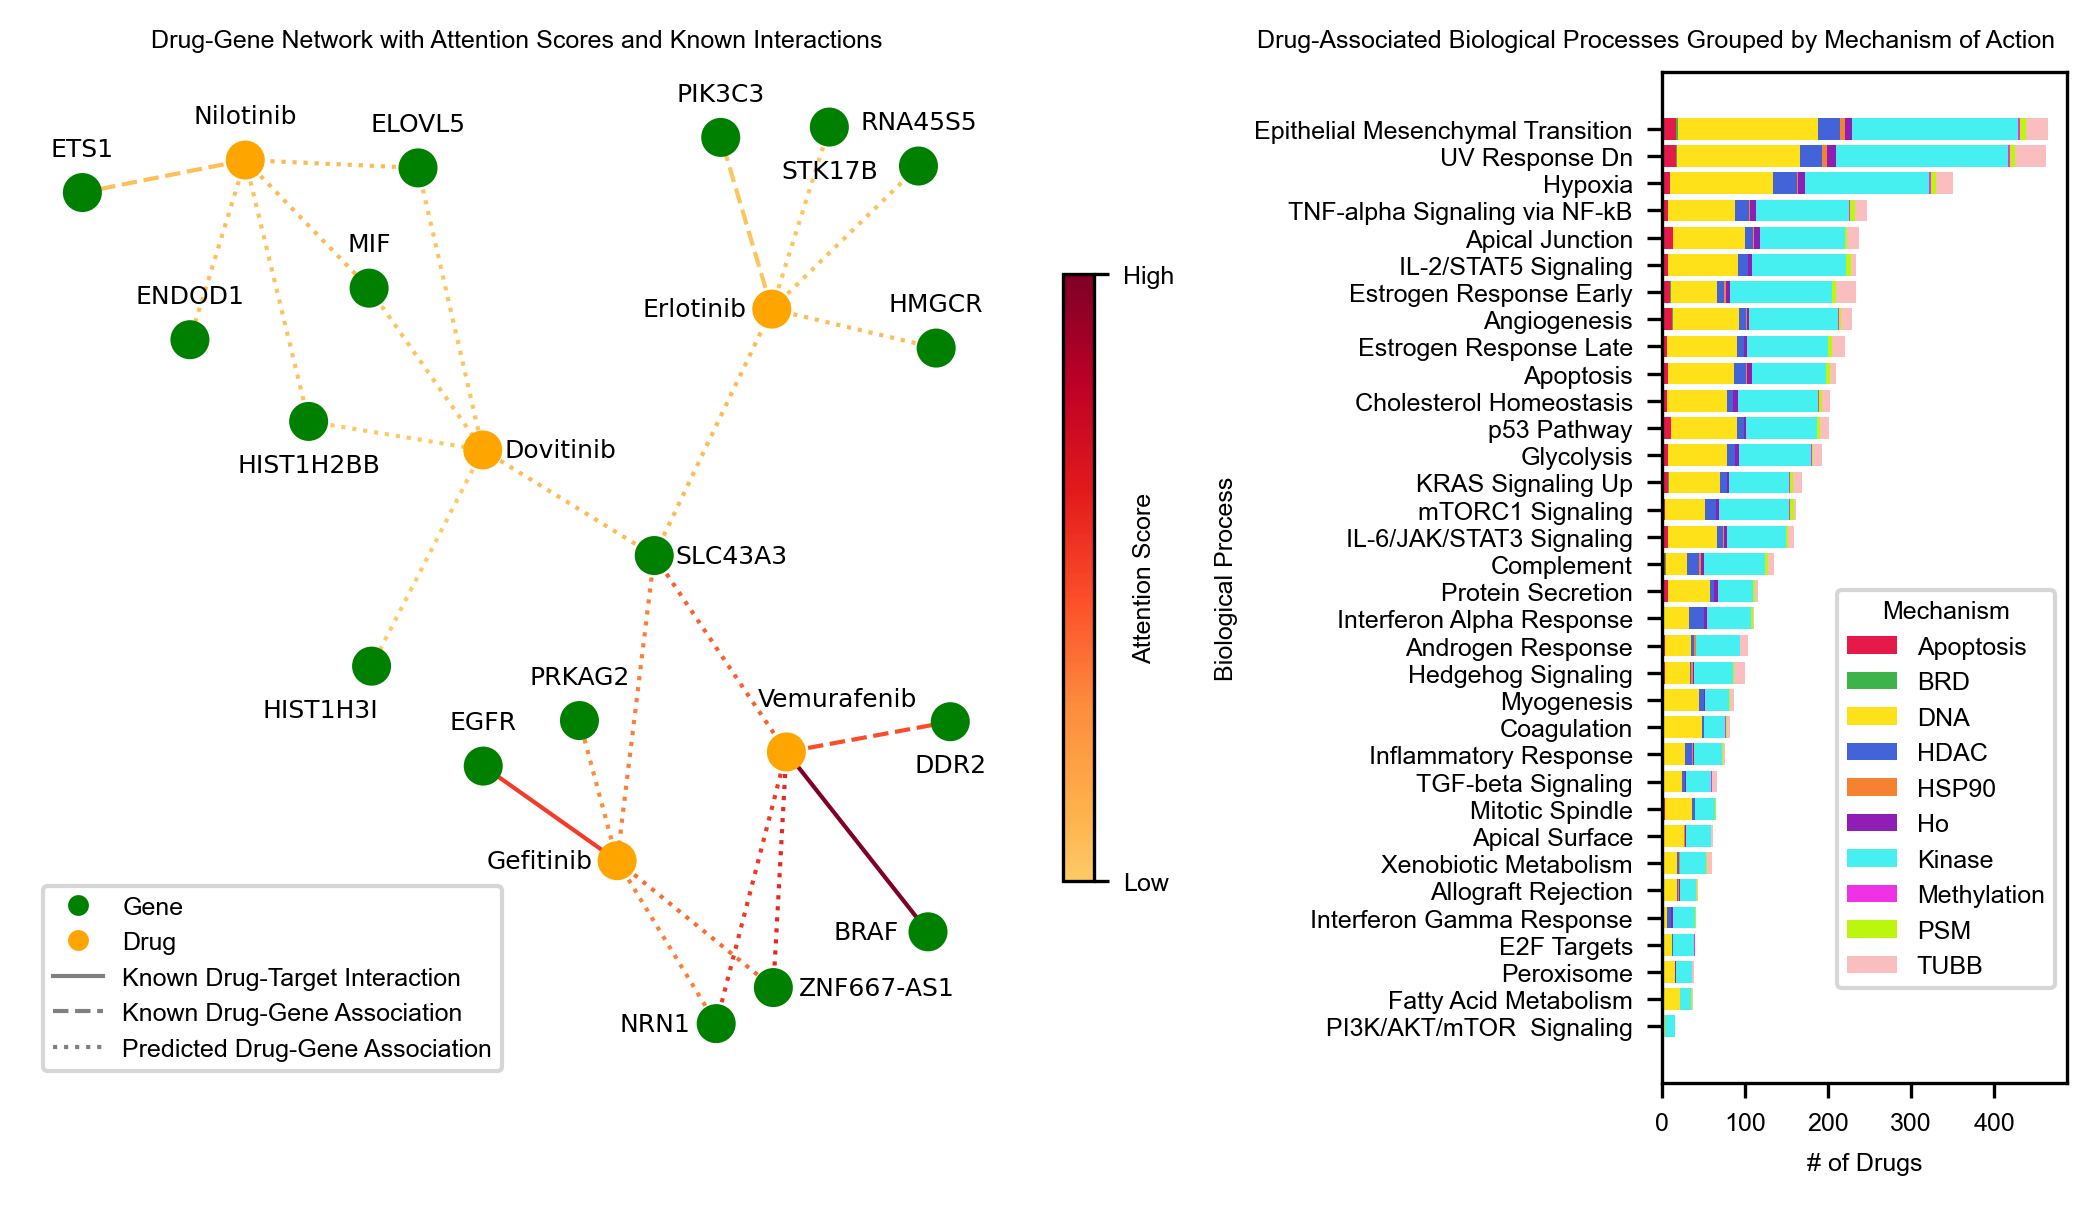

In [8]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
fontsize = 6
plt.rcParams["font.size"] = fontsize
# ← これを冒頭に追加

# Create a figure with two subplots side by side, with the left subplot wider
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(7, 4), dpi=300, gridspec_kw={"width_ratios": [3, 1]}
)

G = nx.from_pandas_edgelist(
    drugs,  # ← df_filtered または対象データフレーム
    source="gene",
    target="drug",
    edge_attr=["atten_score", "dti_existed", "num"],
)

pos = nx.kamada_kawai_layout(G, scale=1)
# pos = nx.spring_layout(G, k=0.7, iterations=200,)
# pos = nx.shell_layout(G)
# pos = {}
# for node in G.nodes():
#     if node in drugs['drug'].values:
#         pos[node] = (1, np.random.rand())
#     else:
#         pos[node] = (0, np.random.rand())
# /

# ノード色分け
genes = set(drugs["gene"])
node_colors = ["green" if node in genes else "orange" for node in G.nodes()]

# エッジと属性
edges = G.edges(data=True)
atten_scores = [attr["atten_score"] for _, _, attr in edges]
norm = plt.Normalize(min(atten_scores), max(atten_scores))
cmap = plt.cm.YlOrRd
cmap_mod = cmap(np.linspace(0.3, 1.0, 256))
cmap_mod = plt.cm.colors.ListedColormap(cmap_mod)


# # ラベル位置調整


target_drug = "Nilotinib"
offset_y = 0.0  # 下にどれだけ移動するか（調整可能）

# Aldoxorubicin本体を移動
pos[target_drug] = (pos[target_drug][0], pos[target_drug][1] + offset_y)

# 隣接するノードも移動
for neighbor in G.neighbors(target_drug):
    pos[neighbor] = (pos[neighbor][0], pos[neighbor][1] + offset_y)


pos["EGFR"] = (pos["EGFR"][0], pos["EGFR"][1] + 0.3)
pos["PRKAG2"] = (pos["PRKAG2"][0], pos["PRKAG2"][1] + 0.5)
pos["ENDOD1"] = (pos["ENDOD1"][0], pos["ENDOD1"][1] - 0.5)

pos["STK17B"] = (pos["STK17B"][0], pos["STK17B"][1] - 0.1)
pos["PIK3C3"] = (pos["PIK3C3"][0], pos["PIK3C3"][1] - 0.1)

label_pos = {k: (v[0], v[1] + 0.05) for k, v in pos.items()}

label_pos["Gefitinib"] = (pos["Gefitinib"][0] - 0.15, pos["Gefitinib"][1])  # 左へ
label_pos["Vemurafenib"] = (
    pos["Vemurafenib"][0] + 0.1,
    pos["Vemurafenib"][1] + 0.06,
)  # 右へ
label_pos["NRN1"] = (pos["NRN1"][0] - 0.12, pos["NRN1"][1])  # 右へ
label_pos["ZNF667-AS1"] = (pos["ZNF667-AS1"][0] + 0.2, pos["ZNF667-AS1"][1])  # 右へ

label_pos["Erlotinib"] = (pos["Erlotinib"][0] - 0.15, pos["Erlotinib"][1])  # 左へ
label_pos["Dovitinib"] = (pos["Dovitinib"][0] + 0.15, pos["Dovitinib"][1])  # 左へ


label_pos["BRAF"] = (pos["BRAF"][0] - 0.12, pos["BRAF"][1])  # 右へ
label_pos["SLC43A3"] = (pos["SLC43A3"][0] + 0.15, pos["SLC43A3"][1])  # 右へ

label_pos["DDR2"] = (pos["DDR2"][0], pos["DDR2"][1] - 0.05)  # 右へ
# label_pos['EGFR'] = (label_pos['EGFR'][0], label_pos['EGFR'][1] + 0.3)

label_pos["STK17B"] = (label_pos["STK17B"][0], label_pos["STK17B"][1] - 0.1)
label_pos["HIST1H3I"] = (label_pos["HIST1H3I"][0] - 0.1, label_pos["HIST1H3I"][1] - 0.1)
label_pos["HIST1H2BB"] = (label_pos["HIST1H2BB"][0], label_pos["HIST1H2BB"][1] - 0.1)

# ノード描画
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=70, ax=ax1)

# エッジ描画
for u, v, attr in edges:
    color = cmap_mod(norm(attr["atten_score"]))

    if attr["dti_existed"] == 1:
        style = "-"
    elif attr["num"] > 0:
        style = "--"
    else:
        style = ":"

    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], edge_color=[color], style=style, width=1, ax=ax1
    )


# ラベル
nx.draw_networkx_labels(G, label_pos, font_size=fontsize, ax=ax1)

# カラーバー
sm = plt.cm.ScalarMappable(cmap=cmap_mod, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, shrink=0.6)
cbar.set_label("Attention Score", fontsize=fontsize, labelpad=-10)

# 実際のatten_scoreに基づいた表示
cbar.set_ticks([min(atten_scores), max(atten_scores)])
cbar.set_ticklabels(["Low", "High"])
cbar.ax.tick_params(labelsize=fontsize)  # ← 追加！

green_patch = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="green",
    markersize=fontsize,
    label="Gene",
)
orange_patch = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="orange",
    markersize=fontsize,
    label="Drug",
)

ax1.legend(
    handles=[
        green_patch,
        orange_patch,
        plt.Line2D(
            [0], [0], color="gray", lw=1, ls="-", label="Known Drug-Target Interaction"
        ),
        plt.Line2D(
            [0], [0], color="gray", lw=1, ls="--", label="Known Drug-Gene Association"
        ),
        plt.Line2D(
            [0],
            [0],
            color="gray",
            lw=1,
            ls=":",
            label="Predicted Drug-Gene Association",
        ),
    ],
    loc="lower left",
    bbox_to_anchor=(0, 0),
)

# タイトル
ax1.set_title(
    "Drug-Gene Network with Attention Scores and Known Interactions", fontsize=fontsize
)
ax1.axis("off")

color_list = [
    "#e6194b",
    "#3cb44b",
    "#ffe119",
    "#4363d8",
    "#f58231",
    "#911eb4",
    "#46f0f0",
    "#f032e6",
    "#bcf60c",
    "#fabebe",
    "#008080",
    "#e6beff",
    "#9a6324",
    "#fffac8",
    "#800000",
    "#aaffc3",
    "#808000",
    "#ffd8b1",
    "#000075",
    "#808080",
    "#ffffff",
    "#000000",
]

# Second plot (Barplot)
agg_df = (
    gea[["Term", "drug", "moa"]]
    .drop_duplicates()
    .groupby(["Term", "moa"])["drug"]
    .count()
    .reset_index(name="Drug Count")
)

# pivotして stacked bar 用の形に変換
pivot_df = agg_df.pivot(index="Term", columns="moa", values="Drug Count").fillna(0)

# 合計で並び替え（多い順）→ barh 用に上下反転
pivot_df = pivot_df.loc[pivot_df.sum(axis=1) >= 10]  # ← この行を追加
pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]
pivot_df = pivot_df[::-1]

columns = list(pivot_df.columns)
if "Other" in columns:
    columns.remove("Other")
    columns.append("Other")
pivot_df = pivot_df[columns]  # この順で列を並べ替え

# 1. カラーマップ指定（必要数を切り出し）
color_map = {
    col: color_list[i % len(color_list)] for i, col in enumerate(pivot_df.columns)
}

# 2. 横棒グラフを1系列ずつ積み上げ
bottom = np.zeros(len(pivot_df))
for col in pivot_df.columns:
    ax2.barh(
        y=pivot_df.index,
        width=pivot_df[col],
        left=bottom,
        label=col,
        color=color_map[col],
    )
    bottom += pivot_df[col].values

# 軸・ラベル設定（元のままでOK）
ax2.set_xlabel("# of Drugs")
ax2.set_ylabel("Biological Process")
ax2.set_title(
    "Drug-Associated Biological Processes Grouped by Mechanism of Action",
    fontsize=fontsize,
    loc="left",
    x=-1,  # ← ラベル切れ回避のため戻す
)

# 凡例
ax2.legend(
    title="Mechanism", bbox_to_anchor=(0.4, 0.5), loc="upper left", fontsize=fontsize
)

plt.tight_layout()
plt.savefig("drug_gene_network.pdf", format="pdf", bbox_inches="tight")  # ← PDF保存
plt.show()

In [81]:
drugs = df[
    df.drug.isin(
        [
            "Topotecan",
            "Camptothecin",
            "Irinotecan",
            "Adriblastin",
            "Daunorubicin",
        ]
    )
]

drugs["drug"] = drugs["drug"].replace("Adriblastin", "Doxorubicin")
drugs = drugs[drugs["NSC"] != 256942]
G = nx.from_pandas_edgelist(drugs, source="drug", target="gene")
nx.is_connected(G)

/tmp/ipykernel_79063/1848342878.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drugs['drug'] = drugs['drug'].replace('Adriblastin', 'Doxorubicin')


False

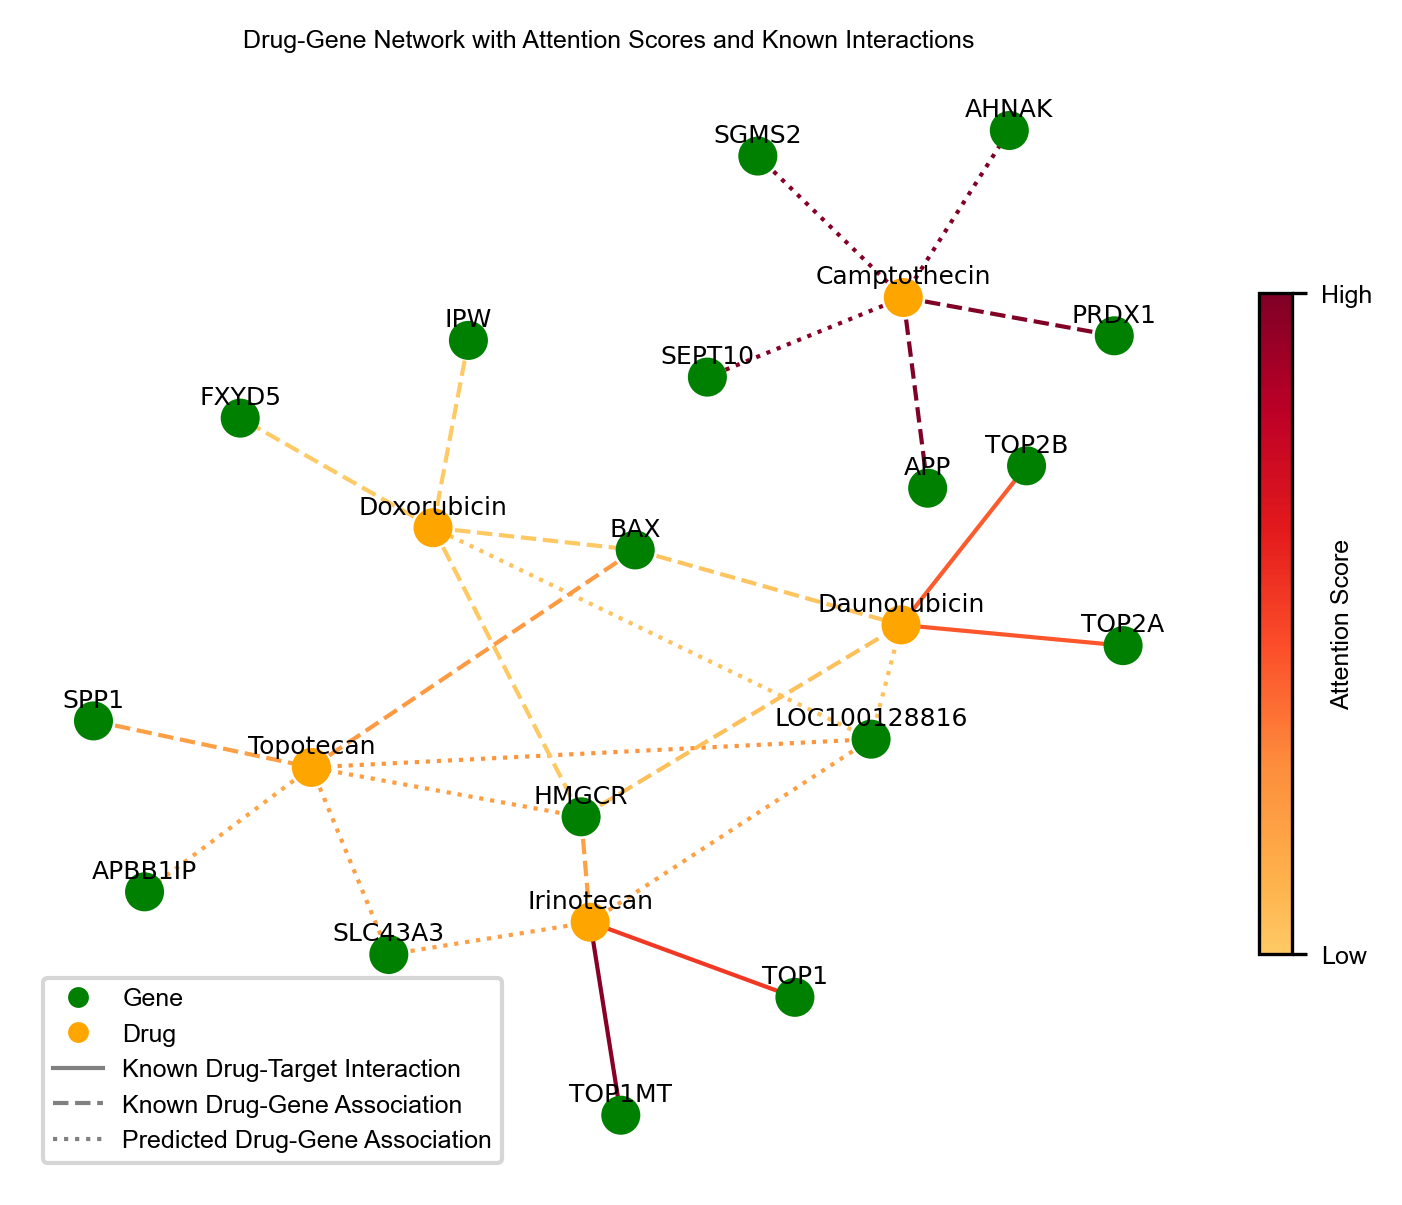

In [105]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
fontsize = 6
plt.rcParams["font.size"] = fontsize

# 左側だけの図を描画（1軸だけ）
fig, ax1 = plt.subplots(figsize=(5, 4), dpi=300)

G = nx.from_pandas_edgelist(
    drugs, source="gene", target="drug", edge_attr=["atten_score", "dti_existed", "num"]
)

pos = nx.kamada_kawai_layout(G, scale=1)

# ノード色分け
genes = set(drugs["gene"])
node_colors = ["green" if node in genes else "orange" for node in G.nodes()]

target_drug = "Camptothecin"
offset_y = 0.7  # 下にどれだけ移動するか（調整可能）
offset_x = 0.5  # 下にどれだけ移動するか（調整可能）

# Aldoxorubicin本体を移動
pos[target_drug] = (pos[target_drug][0] + offset_x, pos[target_drug][1] + offset_y)

# 隣接するノードも移動
for neighbor in G.neighbors(target_drug):
    pos[neighbor] = (pos[neighbor][0] + offset_x, pos[neighbor][1] + offset_y)


target_drug = "Daunorubicin"
offset_y = 0  # 下にどれだけ移動するか（調整可能）
offset_x = 0.5  # 下にどれだけ移動するか（調整可能）

# Aldoxorubicin本体を移動
pos[target_drug] = (pos[target_drug][0] + offset_x, pos[target_drug][1] + offset_y)

# 隣接するノードも移動
for neighbor in G.neighbors(target_drug):
    pos[neighbor] = (pos[neighbor][0] + offset_x, pos[neighbor][1] + offset_y)


target_drug = "Topotecan"
offset_y = 0.1  # 下にどれだけ移動するか（調整可能）
offset_x = 0  # 下にどれだけ移動するか（調整可能）

# Aldoxorubicin本体を移動
pos[target_drug] = (pos[target_drug][0] + offset_x, pos[target_drug][1] + offset_y)

# 隣接するノードも移動
for neighbor in G.neighbors(target_drug):
    pos[neighbor] = (pos[neighbor][0] + offset_x, pos[neighbor][1] + offset_y)

pos["BAX"] = (pos["BAX"][0], pos["BAX"][1] + 0.1)
pos["HMGCR"] = (pos["HMGCR"][0] - 0.3, pos["HMGCR"][1] - 0.3)
pos["LOC100128816"] = (pos["LOC100128816"][0] + 0.2, pos["LOC100128816"][1] - 0.1)

# エッジ属性
edges = G.edges(data=True)
atten_scores = [attr["atten_score"] for _, _, attr in edges]
norm = plt.Normalize(min(atten_scores), max(atten_scores))
cmap = plt.cm.YlOrRd
cmap_mod = cmap(np.linspace(0.3, 1.0, 256))
cmap_mod = plt.cm.colors.ListedColormap(cmap_mod)

# ノード・エッジ描画
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=70, ax=ax1)
for u, v, attr in edges:
    color = cmap_mod(norm(attr["atten_score"]))
    style = "-" if attr["dti_existed"] == 1 else "--" if attr["num"] > 0 else ":"
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], edge_color=[color], style=style, width=1, ax=ax1
    )


label_pos = {k: (v[0], v[1] + 0.05) for k, v in pos.items()}

# ラベルとカラーバー
nx.draw_networkx_labels(G, label_pos, font_size=fontsize, ax=ax1)

sm = plt.cm.ScalarMappable(cmap=cmap_mod, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, shrink=0.6)
cbar.set_label("Attention Score", fontsize=fontsize, labelpad=-10)
cbar.set_ticks([min(atten_scores), max(atten_scores)])
cbar.set_ticklabels(["Low", "High"])
cbar.ax.tick_params(labelsize=fontsize)

# 凡例
green_patch = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="green",
    markersize=fontsize,
    label="Gene",
)
orange_patch = plt.Line2D(
    [0],
    [0],
    marker="o",
    color="w",
    markerfacecolor="orange",
    markersize=fontsize,
    label="Drug",
)

ax1.legend(
    handles=[
        green_patch,
        orange_patch,
        plt.Line2D(
            [0], [0], color="gray", lw=1, ls="-", label="Known Drug-Target Interaction"
        ),
        plt.Line2D(
            [0], [0], color="gray", lw=1, ls="--", label="Known Drug-Gene Association"
        ),
        plt.Line2D(
            [0],
            [0],
            color="gray",
            lw=1,
            ls=":",
            label="Predicted Drug-Gene Association",
        ),
    ],
    loc="lower left",
    bbox_to_anchor=(0, 0),
)

# タイトルと軸の非表示
ax1.set_title(
    "Drug-Gene Network with Attention Scores and Known Interactions", fontsize=fontsize
)
ax1.axis("off")

plt.tight_layout()
plt.savefig("drug_gene_network_left_only.pdf", format="pdf", bbox_inches="tight")
plt.show()